In [1]:
import pandas as pd
import json
import requests
from matplotlib import pyplot as plt

In [2]:
# STATS THAT I WANT TO RECORD:
# Gametype winrate, accuracy by weapon, map winrate, k/d by gametype, k/d by map, assists?, objective?

In [147]:
player_gamertags = ['Wumbology']
# user_input = input('Input player gamertags to compare one at a time. When done, input # : ')

# while user_input != '*':
#     player_gamertags.append(user_input)
#     user_input = input('Input player gamertags to compare one at a time. When done, input # : ')
#     if user_input == '#':
#         break
    

# player_gamertags = ['ElamAce', 'Sparty TG', 'Wumbology']

player_data = {}
# rank, winrate, games played, favorite gametype, favorite weapon

player_data_gbv = {}
# winrate, objective data?, k/d, assists?, number of games

# player_data_gbv_df = pd.DataFrame()

player_data_match = {}
# winrate, k/d,  


gbv = ['Strongholds',
 'Slayer',
 'Breakout',
 'Capture the Flag',
 'Warzone Assault',
 'Warzone',
 'Campaign',
 'Big Team CTF',
 'Big Team Strongholds',
 'Big Team Slayer',
  None,
 'Assault',
 'Grifball',
 'Warzone Firefight',
 'Infection',
 'Campaign Score Attack',
 'Mini-game',
 'Oddball',
 'Big Team Assault']

class Api:
    """  
    This class will call the Halo 5 API and create a dataframe with data for each of
    the provided gamertags
    """
    __api_key = '7022fb201e5a4b35bdf2104472004f9c'
    
    game_base_variants = {}
    
    headers = {
    'Ocp-Apim-Subscription-Key' : __api_key
}
    
    params = {
    'players' : player_gamertags,
}
    
    paramsmatch = {
    'players' : player_gamertags,
    'count' : 25
}
    
    arena_service_record = 'https://www.haloapi.com/stats/h5/servicerecords/arena'
    
    gbv_url = 'https://www.haloapi.com/metadata/h5/metadata/game-base-variants'
    
    maps_url = None
    
    def __init__(self):
        self.resultcount25 = True
        self.match_columns = ['Map', 'Game Mode', 'Total Kills', 'Total Deaths', 'Total Assists']
        self.counter = 0
        self.paramsmatch = {
        'players' : player_gamertags,
        'count' : 25,
        'start' : self.counter
    }
    
    def retrieve_gbv_data(self):
        try:
            req = requests.get(self.arena_service_record, params=self.params, headers=self.headers)
            data = req.json()
            for gamertags in range(len(player_gamertags)):
                player_data_gbv[player_gamertags[gamertags]] = pd.DataFrame(data['Results'][gamertags]['Result']['ArenaStats']['ArenaGameBaseVariantStats'])
        except:
            print(req.status_code)
            print('Error retrieving data')
            
    def retrieve_match_data(self):
        
        for x in range(len(player_gamertags)):
            player_data_match[player_gamertags[x]] = pd.DataFrame(columns=self.match_columns)
            while self.resultcount25 == True:
                matchreq = requests.get(f'https://www.haloapi.com/stats/h5/players/{player_gamertags[x]}/matches', params = self.paramsmatch, headers = self.headers)
                matchdata = matchreq.json()
                for index, value in enumerate(matchdata['Results']):
                    player_data_match[player_gamertags[x]]['Map'][f'{self.counter}'] = matchdata['Results'][index]['MapId']
                    player_data_match[player_gamertags[x]]['Game Mode'][f'{self.counter}'] = None
                    player_data_match[player_gamertags[x]]['Total Kills'][f'{self.counter}'] = None
                    player_data_match[player_gamertags[x]]['Total Deaths'][f'{self.counter}'] = None
                    player_data_match[player_gamertags[x]]['Total Assists'][f'{self.counter}'] = None
                    self.counter += 1
                    if matchdata['ResultCount'] < 25:
                        self.resultcount25 = False
                    elif self.counter > 500:
                        self.resultcount25 = False
                
#                 if matchdata['ResultCount'] == 25:
#                     matchreq = requests.get(f'https://www.haloapi.com/stats/h5/players/{player_gamertags[x]}/matches', params = self.paramsmatch, headers = self.headers)
#                     matchdata = matchreq.json()
#                     for index, value in enumerate(matchdata['Results']):
#                         player_data_match[player_gamertags[x]]['Map'][f'{self.counter}'] = matchdata['Results'][index]['MapId']
#                         self.counter += 1
#                 elif matchdata['ResultCount'] < matchdata['Count']:
#                     matchreq = requests.get(f'https://www.haloapi.com/stats/h5/players/{player_gamertags[x]}/matches', params = self.paramsmatch, headers = self.headers)
#                     matchdata = matchreq.json()
#                     for index, value in enumerate(matchdata['Results']):
#                         player_data_match[player_gamertags[x]]['Map'][f'{self.counter}'] = matchdata['Results'][index]['MapId']
#                         self.counter += 1
#                         if index == matchdata['ResultCount']:
#                             self.resultcount25 = False
#                 elif self.counter > 500:
#                     self.resultcount25 = False
                    
                    
#                 for index, value in enumerate(matchdata['Results']):
#                     player_data_match[player_gamertags[x]]['Map'][f'{self.counter}'] = matchdata['Results'][index]['MapId']
#                     self.counter += 1
#                 matchreq = requests.get(f'https://www.haloapi.com/stats/h5/players/{player_gamertags[x]}/matches', params = self.paramsmatch, headers = self.headers)
#                 matchdata = matchreq.json()
                
#             if matchdata['ResultCount'] == 25:
#                 for index, value in enumerate(matchdata['Results']):
#                     player_data_match[player_gamertags[x]]['Map'][f'{self.counter}'] = matchdata['Results'][index]['MapId']
#                     self.counter += 1               
#             elif matchdata['ResultCount'] <= matchdata['Count']:
#                 for index, value in enumerate(matchdata['Results']):
#                     player_data_match[player_gamertags[x]]['Map'][f'{self.counter}'] = matchdata['Results'][index]['MapId']
#                     self.counter += 1
#                     if index == matchdata['ResultCount']:
#                         break
#             elif self.counter > 500:
#                 break
        
    def retrieve_metadata(self, url):
        self.url = url
        req = requests.get(self.url, headers = self.headers)
        data = req.json()
        self.game_base_variants = pd.DataFrame(data)
        
class DataClean:
    """
    This class will replace the the Id values with metadata values retrieved from the metadata API.
    It will also remove unneeded columns and and construct a dataframe of desired data.
    """
    
    metadata_id = {}
    
    def __init__(self):
        call_api = None
        metadata_replace = None
        metadata_id = None
    
    def gbv_data_clean(self):
        
        self.call_api = Api()
        self.call_api.retrieve_metadata(self.call_api.gbv_url)
        self.metadata_replace = pd.DataFrame(self.call_api.game_base_variants)
        self.metadata_id = pd.Series(self.metadata_replace.name.values,index=self.metadata_replace.id).to_dict()
        
        for i in range(len(player_gamertags)):
            for x in range(len(player_data_gbv[player_gamertags[i]]['GameBaseVariantId'])):
                # this takes the metadata taken from the API and replaces the metadata id with the actual game mode name
                player_data_gbv[player_gamertags[i]]['GameBaseVariantId'][x] = self.metadata_id[player_data_gbv[player_gamertags[i]]['GameBaseVariantId'][x]]
        
        for i in range(len(player_gamertags)):
            # renames the column from GameBaseVariantId to Game Mode
            player_data_gbv[player_gamertags[i]].rename(columns = {
                'GameBaseVariantId' : 'Game Mode'
            }, inplace=True)
        
        for x in range(len(player_gamertags)):
            # adds a column for win percentage based on total games/games won*100
            # adds a column for kill/death ration based on total kills/total deaths
            
            player_data_gbv[player_gamertags[x]]['Win Percentage'] = (player_data_gbv[player_gamertags[x]]['TotalGamesWon'] / player_data_gbv[player_gamertags[x]]['TotalGamesCompleted'])*100
            player_data_gbv[player_gamertags[x]]['K/D Ratio'] = player_data_gbv[player_gamertags[x]]['TotalKills'] / player_data_gbv[player_gamertags[x]]['TotalDeaths']
            player_data_gbv[player_gamertags[x]]['PowerWeaponGrabs/Game'] = player_data_gbv[player_gamertags[x]]['TotalPowerWeaponGrabs'] / player_data_gbv[player_gamertags[x]]['TotalGamesCompleted']
        
        for x in range(len(player_gamertags)):
            player_data_gbv[player_gamertags[x]] = player_data_gbv[player_gamertags[x]][['Game Mode', 'Win Percentage', 'TotalGamesCompleted', 'K/D Ratio', 'TotalKills', 'TotalDeaths', 'TotalAssists', 'PowerWeaponGrabs/Game', 'TotalGamesWon', 'TotalGamesLost']]
            player_data_gbv[player_gamertags[x]].set_index('Game Mode', inplace=True)
                
class CompareStats:
    """
    This class will use the other two classes to pull and clean player stats data
    in order to compare them
    """
    def __init__(self):
        
        self.call_api = Api()
        self.call_api.retrieve_gbv_data()
        self.replace_metadata = DataClean()
        self.replace_metadata.gbv_data_clean()
        
        self.gbv_dataframe = None
        self.gbv_columns = ['Win Percentage', 'TotalGamesCompleted', 'K/D Ratio', 'TotalKills', 'TotalDeaths', 'TotalAssists', 'PowerWeaponGrabs/Game', 'TotalGamesWon', 'TotalGamesLost']
        
        
        
    def player_data(self):
        pass
    
    def gbv_data(self):
        #
        
        self.gbv_dataframe = pd.DataFrame()
        self.gbv_dataframe['Game Mode'] = gbv
        # making a dataframe where the index will be all of the possible gametypes
    
        for i in range(len(self.gbv_columns)):
            for x in range(len(player_gamertags)):
                # make a column named stats: gamertag for each of the gamertags that are being compared
                self.gbv_dataframe[f'{self.gbv_columns[i]}: {player_gamertags[x]}'] = None
        
          
        for i in range(len(self.gbv_dataframe)):
            for x in range(len(player_gamertags)):
                # if the gamertags provided have data for the gametype, then created a column for that player for each of the
                # stats we are including
                if self.gbv_dataframe['Game Mode'][i] in player_data_gbv[player_gamertags[x]].index:
                    for c in range(len(self.gbv_columns)):
                        self.gbv_dataframe[f'{self.gbv_columns[c]}: {player_gamertags[x]}'][i] = player_data_gbv[player_gamertags[x]][f'{self.gbv_columns[c]}'][self.gbv_dataframe['Game Mode'][i]]
        
        self.gbv_dataframe.set_index('Game Mode', inplace=True)
        self.gbv_dataframe.dropna(how='all', inplace=True)
        # drop all rows (gametypes) that were not played at all by any of the given gamertags
        
    def gametype_graph_bar(self, stat, gametype):
        
        self.stat = stat
        self.gametype = gametype
        self.gbv_dataframe.fillna(value=0, inplace=True)

        for x in range(len(player_gamertags)):   
                # for every gt
                    # for every game mode
            plt.bar(player_gamertags[x], self.gbv_dataframe[f'{self.stat}: {player_gamertags[x]}'][f'{self.gametype}'])
            plt.ylabel(f'{self.stat}')
            plt.title(f'Game Mode: {self.gametype}')
        plt.show()
        
    def map_data(self):
        pass
    
            

In [148]:
halo = Api()
halo.retrieve_match_data()
player_data_match[player_gamertags[0]]['Map']

KeyError: 'Results'

In [ ]:
player_data_gbv[player_gamertags[0]]['TotalKills'][0]
player_data_gbv[player_gamertags[0]]['TotalKills']

C:\Users\hunte\anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


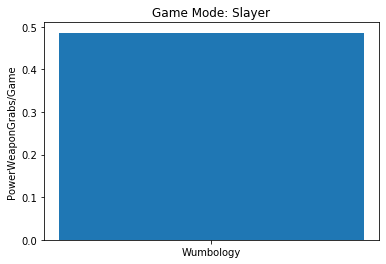

In [48]:
halo5 = CompareStats()
halo5.gbv_data()
halo5.gametype_graph_bar('PowerWeaponGrabs/Game', 'Slayer')

In [24]:
player_data_gbv[player_gamertags[0]]

,Win Percentage,TotalGamesCompleted,K/D Ratio,TotalKills,TotalDeaths,TotalAssists,PowerWeaponGrabs/Game,TotalGamesWon,TotalGamesLost
Game Mode,,,,,,,,,
Strongholds,76.723439,2466,1.470327,35157,23911,18318,0.387672,1892,574
Breakout,71.544715,246,1.578898,1691,1071,630,0.028455,176,70
Slayer,69.736444,3301,1.416012,49188,34737,21990,0.827325,2302,997
Big Team Slayer,77.777778,9,1.779221,137,77,58,0.777778,7,2
Big Team CTF,100.000000,3,2.250000,54,24,25,0.333333,3,0
Oddball,66.359447,217,1.256232,3981,3169,1963,0.456221,144,73
Capture the Flag,73.530588,2501,1.378323,37591,27273,18966,0.670532,1839,645
Mini-game,100.000000,2,1.727273,19,11,5,0.000000,2,0
Assault,76.818182,220,1.612198,4203,2607,1994,0.800000,169,46


In [52]:
# halo5 = CompareStats()
# halo5.gbv_data()
halo5.gbv_dataframe['Win Percentage: Wumbology']['Slayer']

55.633802816901415

In [34]:
player_data_gbv[player_gamertags[0]]

,Win Percentage,TotalGamesCompleted,K/D Ratio,TotalKills,TotalDeaths,TotalAssists,PowerWeaponGrabs/Game,TotalGamesWon,TotalGamesLost
Game Mode,,,,,,,,,
Strongholds,76.723439,2466,1.470327,35157,23911,18318,0.387672,1892,574
Breakout,71.544715,246,1.578898,1691,1071,630,0.028455,176,70
Slayer,69.736444,3301,1.416012,49188,34737,21990,0.827325,2302,997
Big Team Slayer,77.777778,9,1.779221,137,77,58,0.777778,7,2
Big Team CTF,100.000000,3,2.250000,54,24,25,0.333333,3,0
Oddball,66.359447,217,1.256232,3981,3169,1963,0.456221,144,73
Capture the Flag,73.530588,2501,1.378323,37591,27273,18966,0.670532,1839,645
Mini-game,100.000000,2,1.727273,19,11,5,0.000000,2,0
Assault,76.818182,220,1.612198,4203,2607,1994,0.800000,169,46


In [483]:
df = pd.DataFrame(data=None, columns=['Game Mode', 'Win Percentage', 'TotalGamesCompleted', 'K/D Ratio', 'TotalKills', 'TotalDeaths', 'TotalAssists', 'TotalPowerWeaponGrabs', 'TotalGamesWon', 'TotalGamesLost'])

In [484]:
df

,Game Mode,Win Percentage,TotalGamesCompleted,K/D Ratio,TotalKills,TotalDeaths,TotalAssists,TotalPowerWeaponGrabs,TotalGamesWon,TotalGamesLost


In [34]:
halo5.gbv_dataframe

,Win Percentage: ElamAce,Win Percentage: Sparty TG,Win Percentage: Wumbology,TotalGamesCompleted: ElamAce,TotalGamesCompleted: Sparty TG,TotalGamesCompleted: Wumbology,K/D Ratio: ElamAce,K/D Ratio: Sparty TG,K/D Ratio: Wumbology,TotalKills: ElamAce,...,TotalAssists: Wumbology,PowerWeaponGrabs/Game: ElamAce,PowerWeaponGrabs/Game: Sparty TG,PowerWeaponGrabs/Game: Wumbology,TotalGamesWon: ElamAce,TotalGamesWon: Sparty TG,TotalGamesWon: Wumbology,TotalGamesLost: ElamAce,TotalGamesLost: Sparty TG,TotalGamesLost: Wumbology
Game Mode,,,,,,,,,,,,,,,,,,,,,
Strongholds,76.723439,77.115275,56.000000,2466,3522,25,1.470327,1.644159,1.612565,35157,...,130,0.387672,0.395798,0.880000,1892,2716,14,574,805,11
Slayer,69.736444,75.610891,55.633803,3301,4297,142,1.416012,1.818464,1.510654,49188,...,630,0.827325,0.834536,0.485915,2302,3249,79,997,1045,62
Breakout,71.544715,77.835951,52.000000,246,573,25,1.578898,2.275418,1.663158,1691,...,37,0.028455,0.247818,0.000000,176,446,13,70,127,12
Capture the Flag,73.530588,76.624098,54.838710,2501,3602,31,1.378323,1.646863,1.698925,37591,...,160,0.670532,0.644919,0.741935,1839,2760,17,645,799,14
Big Team CTF,100.000000,50.000000,0.000000,3,2,0,2.250000,2.857143,0.000000,54,...,0,0.333333,0.000000,0.000000,3,1,0,0,1,0
Big Team Strongholds,75.000000,100.000000,0.000000,8,2,0,2.021277,2.363636,0.000000,190,...,0,0.875000,0.000000,0.000000,6,2,0,2,0,0
Big Team Slayer,77.777778,50.000000,100.000000,9,2,1,1.779221,2.428571,11.500000,137,...,7,0.777778,0.000000,1.000000,7,1,1,2,1,0
Assault,76.818182,76.696165,50.000000,220,339,2,1.612198,1.934731,1.466667,4203,...,9,0.800000,0.728614,0.000000,169,260,1,46,66,1
Grifball,62.500000,66.666667,0.000000,8,9,0,1.720339,1.213542,0.000000,203,...,0,0.000000,0.000000,0.000000,5,6,0,3,3,0
